# Note that at this point in development I noticed that some of the audio clips in the database are duplicated, so these are cleaned out. 
Guidelines adapted from the google Data Prep and Feature Engineering In ML course.<br>

https://developers.google.com/machine-learning/data-prep

Size and quality
- The size and quality of the dataset matters more than what model and training protocol is used. Garbage in, garbage out. 
- As a rule of thumb, the model should train on at least one order of magnitude more examples than trainable parameters. 

Reliability
- How common are label errors? If the dataset is labeled by humans, then how often do mistakes occur?
- Missing values
- Duplicated examples
- Mis-labeled examples
- Bad features (e.g low quality encoding) 

During training, use only the features that you'll have available in serving, and make sure your training set is representative of your serving traffic.


The Golden Rule: Do unto training as you would do unto prediction. That is, the more closely your training task matches your prediction task, the better your ML system will perform. 

### Steps to constructing a dataset
1. Collect the raw data
Currently the raw data for the osfl song clips is downloaded, and the raw data for the no_song dataset is on AWS cloud servers. 
2. Identify feature and label sources
Features will be from the shapes in the spectrogram images. Labels are human labelled tags. 
3. Select sampling strategy
4. Split the data. 



If data is restricted and a sample needs to be taken, ensure the data is spread out temporally, to reduce seasonal variation effects. Similarly ensure that the data comes from different locations to include spatial variation effects. 

_A note on unbalanced data:_

Normally when there's a class imbalance in a dataset, the abundant class is downsampled, then examples from this class are weighted proportionally to the amount by which the class is downsampled. For example, if there are 100 case A for every 1 case B, then we might downsample case A by a factor of 10, so that the ratio of A to B is 10:1 instead of 100:1 in each mini batch. 

To keep the model calibrated, we'd want to calculate the loss for examples in A as being 10 times as important as if we hadn't downsampled. This keeps the model's outputs calibrated in the sense that the outputs can still be treated as probabilities. 

However, we're constructing an artificial dataset here. We can choose for the classes to be equally weighted: the 'song' clips can be exactly as numerous as the 'no-song' clips. 

From the perspective of the model in deployment however, the ratio of song to no-song will be much different. Firstly because there is generally more silence than birdsong in the real environment. Another consideration is that if a signal detection algorithm is used, then this will filter out a lot of the silence, and change the class balance again depending on the features of the algorithm. 

In addition, we don't need the actual probability that we detected a bird - only numbers proportional to the probability - since we can pick a threshold for the recognizer. 

With all this considered, I've decided the simplest approach is to create an equally balanced dataset of song / no-song clips then train a model on these, and come back to the issue of class imbalance if it arises later. 



Train test split
- This should be smarter than a simple random shuffle of all the data, because a model can learn the specific background noises present at a location, then use this information, rather than the shape / sound of a bird's song, to make a prediction. 

- It would be better to split the validation set from completely separate ARUs
- alternatives: split by day, split by project, split by location. 


Once the data split has been decdied, download the relevant audio files and cut the audio segments from the downloaded files. 
If necessary, throw these away to save disk space, or do this in the cloud and download only the  clips. 

Throughout the data building phase, keep plotting scattergraphs and bar plots to make sure the distribution of the data matches expectations and is balanced. 



### Is the model just learning the acoustic signature of the ARUs which recorded an olive sided flycatcher?

It is important to make sure that the datasets contain positive and negative examples of recordings from the same ARUs to stop the model from learning a prediction such as 'if the background noise is like this, then predict olive sided flycatcher'. This could have been happening with the dummy datasets if the osfl clips tended to be clustered around certain ARUs and habitats, and the other vocalizations were from a more diverse spread of locations.



In [1]:
import sys
sys.path.append('../../src')

import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import data.clean_csv
from utils import *

%conda install geopandas -y
import geopandas as gpd
# process the raw csv file (optional)
# clean_csv.process_raw_csv()

%load_ext autoreload
%autoreload 2

Retrieving notices: ...working... done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.9.0
  latest version: 23.10.0

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.10.0



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [33]:
data_path = Path('../../data')
df_full = pd.read_pickle(data_path / 'interim' / 'processed_metadata.pkl')
df_full.columns

Index(['organization', 'project', 'project_id', 'location', 'location_id',
       'recording_date_time', 'recording_id', 'task_method', 'task_id',
       'aru_task_status', 'species_code', 'species_common_name',
       'species_scientific_name', 'species_class', 'detection_time',
       'task_duration', 'tag_duration', 'min_tag_freq', 'max_tag_freq',
       'tag_id', 'individual_order', 'vocalization', 'abundance', 'tag_rating',
       'tag_is_verified', 'clip_channel_used', 'observer', 'observer_id',
       'verifier_id', 'left_full_freq_tag_rms_peak_dbfs',
       'left_full_freq_tag_rms_trough_dbfs', 'left_full_freq_tag_pk_count',
       'left_full_freq_tag_dc_offset', 'left_full_freq_tag_min_level',
       'left_full_freq_tag_max_level', 'left_full_freq_tag_peak_level_dbfs',
       'left_freq_filter_tag_rms_peak_dbfs',
       'left_freq_filter_tag_rms_trough_dbfs', 'left_freq_filter_tag_pk_count',
       'left_freq_filter_tag_dc_offset', 'left_freq_filter_tag_min_level',
       'lef

In [34]:

keep_cols = ['organization', 'project', 'project_id', 'recording_id', 'recording_date_time', 'species_code', 'species_common_name', 'detection_time', 'task_duration', 'tag_duration', 'tag_id', 'clip_url', 'recording_url', 'latitude', 'longitude', 'file_type']
df = df_full[keep_cols]

In [35]:
display_all(df_full.head())


,organization,project,project_id,location,location_id,recording_date_time,recording_id,task_method,task_id,aru_task_status,species_code,species_common_name,species_scientific_name,species_class,detection_time,task_duration,tag_duration,min_tag_freq,max_tag_freq,tag_id,individual_order,vocalization,abundance,tag_rating,tag_is_verified,clip_channel_used,observer,observer_id,verifier_id,left_full_freq_tag_rms_peak_dbfs,left_full_freq_tag_rms_trough_dbfs,left_full_freq_tag_pk_count,left_full_freq_tag_dc_offset,left_full_freq_tag_min_level,left_full_freq_tag_max_level,left_full_freq_tag_peak_level_dbfs,left_freq_filter_tag_rms_peak_dbfs,left_freq_filter_tag_rms_trough_dbfs,left_freq_filter_tag_pk_count,left_freq_filter_tag_dc_offset,left_freq_filter_tag_min_level,left_freq_filter_tag_max_level,left_freq_filter_tag_peak_level_dbfs,right_full_freq_tag_rms_peak_dbfs,right_full_freq_tag_rms_trough_dbfs,right_full_freq_tag_pk_count,right_full_freq_tag_dc_offset,right_full_freq_tag_min_level,right_full_freq_tag_max_level,right_full_freq_tag_peak_level_dbfs,right_freq_filter_tag_rms_peak_dbfs,right_freq_filter_tag_rms_trough_dbfs,right_freq_filter_tag_pk_count,right_freq_filter_tag_dc_offset,right_freq_filter_tag_min_level,right_freq_filter_tag_max_level,right_freq_filter_tag_peak_level_dbfs,tagged_in_wildtrax,media_url,spectrogram_url,clip_url,sensorId,tasks,status,recording_url,latitude,longitude,location_buffer_m,file_type
1623,BU,Alberta Archetypes,1501,P-E0-1-10,308678,2022-06-05 06:51:00,416962,nan,596169,Transcribed,OVEN,Ovenbird,SEIURUS AUROCAPILLA,Aves,67.8,180.0,3.94,1.08kHz,11.38kHz,3212415,1.0,Song,1,NaN,f,1.0,Alex MacPhail,15,-1,-19.20,-45.60,2.0,0.000014,-0.392700,0.398468,-7.99,-19.21,-57.44,2.0,0.000000,-0.399567,0.387360,-7.97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,https://portal.wildtrax.ca/home/aru-tasks/reco...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,ARU,357,Active,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,52.644040,-115.140510,NaN,flac
1624,BU,Alberta Archetypes,1501,P-E0-1-10,308678,2022-06-05 06:51:00,416962,nan,596169,Transcribed,OVEN,Ovenbird,SEIURUS AUROCAPILLA,Aves,67.8,180.0,3.94,1.08kHz,11.38kHz,3212415,1.0,Song,1,NaN,f,1.0,Alex MacPhail,15,-1,-19.20,-45.60,2.0,0.000014,-0.392700,0.398468,-7.99,-19.21,-57.44,2.0,0.000000,-0.399567,0.387360,-7.97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,https://portal.wildtrax.ca/home/aru-tasks/reco...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,ARU,357,Active,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,52.644040,-115.140510,NaN,flac
1625,BU,Alberta Archetypes,1501,P-E0-1-10,308678,2022-06-05 06:51:00,416962,nan,596169,Transcribed,OVEN,Ovenbird,SEIURUS AUROCAPILLA,Aves,67.8,180.0,3.94,1.08kHz,11.38kHz,3212415,1.0,Song,1,NaN,f,1.0,Alex MacPhail,15,-1,-19.20,-45.60,2.0,0.000014,-0.392700,0.398468,-7.99,-19.21,-57.44,2.0,0.000000,-0.399567,0.387360,-7.97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,https://portal.wildtrax.ca/home/aru-tasks/reco...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,ARU,357,Active,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,52.644040,-115.140510,NaN,flac
1752,BU,Amplitude Quality Testing 2020,293,AM-403-SE2,36043,2017-06-15 04:46:00,92051,nan,87956,Transcribed,LINO,Light continuous industrial noise,nan,Abiotic,0.0,180.0,4.05,0.00kHz,2.10kHz,1462249,1.0,Song,1,NaN,f,2.0,Brandon Law,22,-1,-31.23,-41.36,2.0,0.000032,-0.068624,0.064758,-23.27,-31.79,-42.37,2.0,0.000014,-0.053301,0.052177,-25.47,-29.25,-39.74,2.0,0.000028,-0.081295,0.076209,-21.8,-29.79,-40.6,2.0,0.000009,-0.069424,0.063139,-23.17,t,https://portal.wildtrax.ca/home/aru-tasks/reco...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,ARU,174,Published - Private,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,5

Check some assumptions about the data: 

In [36]:
# 1. all the clip ids are unique
df_full.tag_id.value_counts()

tag_id
2301628    7
2232735    7
2232727    7
2232731    7
2232728    7
          ..
2557730    1
2557729    1
2557728    1
2557727    1
3339448    1
Name: count, Length: 544399, dtype: int64

In [37]:
df.loc[df['tag_id'] == 2301628].clip_url.values

array(['https://wildtrax-aru.s3.us-west-2.amazonaws.com/7ffbd831-4e4d-4877-acf3-aecebadc2593/6bedf76801f14d9882ee73f81edc472f.mp3',
       'https://wildtrax-aru.s3.us-west-2.amazonaws.com/7ffbd831-4e4d-4877-acf3-aecebadc2593/6bedf76801f14d9882ee73f81edc472f.mp3',
       'https://wildtrax-aru.s3.us-west-2.amazonaws.com/7ffbd831-4e4d-4877-acf3-aecebadc2593/6bedf76801f14d9882ee73f81edc472f.mp3',
       'https://wildtrax-aru.s3.us-west-2.amazonaws.com/7ffbd831-4e4d-4877-acf3-aecebadc2593/6bedf76801f14d9882ee73f81edc472f.mp3',
       'https://wildtrax-aru.s3.us-west-2.amazonaws.com/7ffbd831-4e4d-4877-acf3-aecebadc2593/6bedf76801f14d9882ee73f81edc472f.mp3',
       'https://wildtrax-aru.s3.us-west-2.amazonaws.com/7ffbd831-4e4d-4877-acf3-aecebadc2593/6bedf76801f14d9882ee73f81edc472f.mp3',
       'https://wildtrax-aru.s3.us-west-2.amazonaws.com/7ffbd831-4e4d-4877-acf3-aecebadc2593/6bedf76801f14d9882ee73f81edc472f.mp3'],
      dtype=object)

# The clips aren't all unique. Build a function to ensure that the database only contains unique clips and recordings to avoid data leakage. 

/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/notebooks/exploratory_nbs/../../src/utils.py:50: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  canada = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres")).query(
/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/notebooks/exploratory_nbs/../../src/utils.py:70: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  points.plot(
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


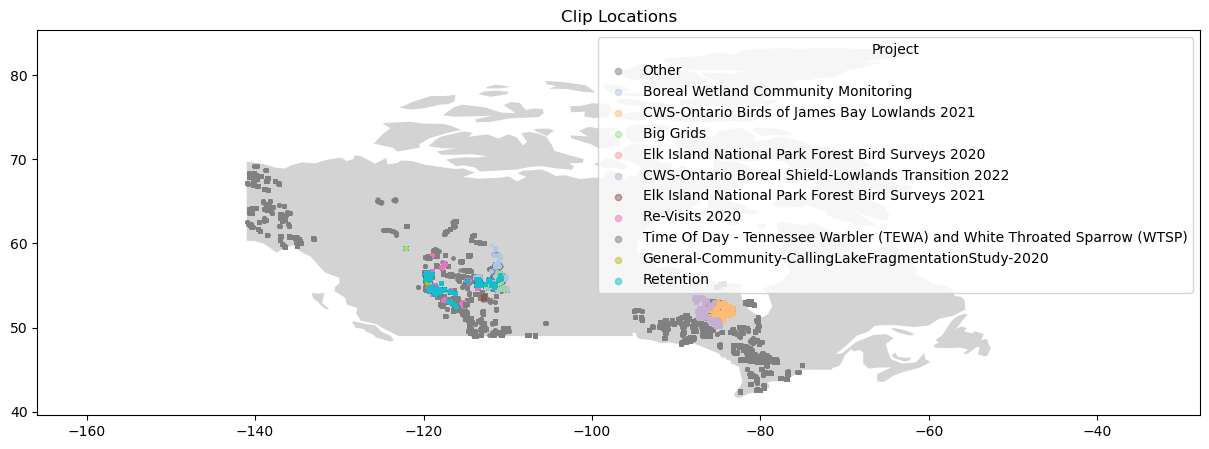

,project_id,recording_id,detection_time,task_duration,tag_duration,tag_id,latitude,longitude
count,1.097135e+06,1.097135e+06,1.097135e+06,1.097135e+06,1.097135e+06,1.097135e+06,1.079860e+06,1.079860e+06
mean,6.761033e+02,2.740676e+05,7.707722e+01,2.563827e+02,2.403144e+00,2.156266e+06,5.402917e+01,-1.078665e+02
std,5.519733e+02,1.946405e+05,1.121438e+02,1.985905e+02,1.484645e+00,8.881851e+05,3.117030e+00,1.297872e+01
min,2.000000e+00,3.557000e+03,0.000000e+00,4.134000e+01,6.000000e-02,1.708400e+04,4.236354e+01,-1.409624e+02
25%,1.500000e+02,1.376920e+05,6.860000e+00,1.800000e+02,1.490000e+00,1.484392e+06,5.308726e+01,-1.144878e+02
50%,6.620000e+02,2.117120e+05,3.431000e+01,1.800000e+02,2.050000e+00,2.288918e+06,5.370755e+01,-1.128401e+02
75%,1.092000e+03,3.822160e+05,1.086500e+02,3.000000e+02,2.990000e+00,2.774890e+06,5.534908e+01,-1.107555e+02
max,2.044000e+03,8.290150e+05,5.990900e+02,6.000000e+02,5.496000e+01,3.528574e+06,6.923258e+01,-7.510290e+01


In [38]:
def filter_duplicate_clips(df: pd.DataFrame) -> pd.DataFrame:
    """Filter out duplicate clips based on tag_id"""
    return df.loc[df.tag_id.drop_duplicates().index]

plot_locations(df)
print_stats(df)

In [39]:
df = filter_duplicate_clips(df)

In [40]:
df.tag_id.value_counts()[:3]

tag_id
3212415    1
1166586    1
1166582    1
Name: count, dtype: int64

In [41]:
len(df),  df.tag_id.nunique(), df.recording_url.nunique(), df.clip_url.nunique()

(544399, 544399, 67927, 544399)

68000 recordings create 544,400 tags. 

# To create a test set, select 20% of the data to remove from the dataset. 
This should be representative of the entire training dataset. Additionally we want to evaluate how the model will generalise to new locations. 
- To achieve this split, one option is to apply a grid to the map, and filter out 20% of the database at the recording level. I'll then make sure that the recordings which were selected also account for around 20% of the olive sided flycatcher clips. It might be necessary to split the data differently. 
TODO
- Look at a table of osfl tags per recording


In [42]:
osfls = df.loc[df.species_code == 'OSFL']
len(osfls)

5085

In [43]:
df.columns

Index(['organization', 'project', 'project_id', 'recording_id',
       'recording_date_time', 'species_code', 'species_common_name',
       'detection_time', 'task_duration', 'tag_duration', 'tag_id', 'clip_url',
       'recording_url', 'latitude', 'longitude', 'file_type'],
      dtype='object')

/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/notebooks/exploratory_nbs/../../src/utils.py:50: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  canada = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres")).query(
/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/notebooks/exploratory_nbs/../../src/utils.py:70: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  points.plot(


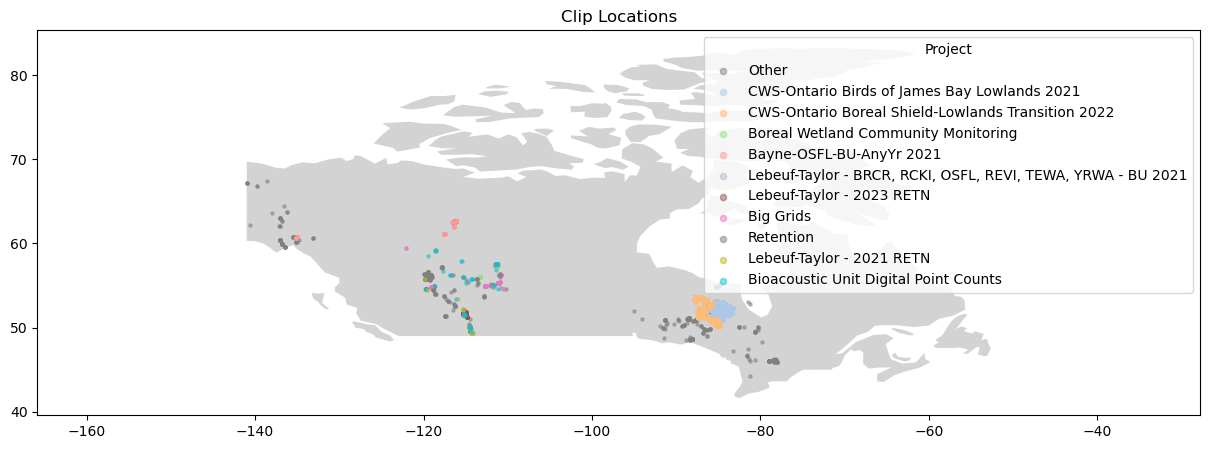

In [44]:
plot_locations(osfls)

In [45]:
osfls.loc[osfls.latitude == osfls.latitude.max()]

,organization,project,project_id,recording_id,recording_date_time,species_code,species_common_name,detection_time,task_duration,tag_duration,tag_id,clip_url,recording_url,latitude,longitude,file_type
2346567,CWS-NOR,YT Boreal Monitoring Program CWS Northern Regi...,285,140875,2019-05-25 03:00:00,OSFL,Olive-sided Flycatcher,14.51,180.0,1.04,1357905,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,67.40775,-138.64234,mp3


In [46]:
df_lite = df.sample(1000)

Re-factored 

In [47]:
def plot_locations_with_legend(df, feature='project', title='Clip Locations', num_features=10, forced_features: list=[None]):
    """
    Plot points from a DataFrame on a map of Canada with a colour legend.
    The points will be coloured based on the top n unique values in the features column.

    Parameters: 
    - df: DataFrame or GeoDataFrame with 'latitude' and 'longitude' and other feature columns. 
    - features: the name of the column used to colour the points.
    - title: the title of plot
    - num_classes: the number of unique values in the features column to plot.
    - forced_classes: additional classes to include in the plot regardless of their count in the features column.
    """
    # Convert DataFrame to GeoDataFrame if needed
    if not isinstance(df, gpd.GeoDataFrame):
        df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

    # Load Canada map
    canada = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres")).query("name == 'Canada'")
    
    # Determine feature labels for coloring
    top_features = df[feature].value_counts().nlargest(num_features).index.to_list()
    all_features =   ['Other'] + top_features + forced_features
    df['_color'] = df[feature].where(df[feature].isin(all_features), 'Other')

    # Create colormap
    color_map = plt.cm.get_cmap('tab20', len(all_features))
    
    # Plot base map
    fig, ax = plt.subplots(figsize=(15, 5))
    canada.plot(color='lightgrey', ax=ax)
    
    # Plot points with legend
    for i, feature_label in enumerate(all_features):
        color = 'grey' if feature_label == 'Other' else color_map(i)
        points = df[df['_color'] == feature_label]
        points.plot(ax=ax, marker='o', color=color, label=feature_label, markersize=5, alpha=0.5)

    # Set aspect to equal for maintaining scale
    ax.set_aspect('equal', adjustable='datalim')

    # Customize and show plot
    ax.set_title(title)
    ax.legend(title=feature.capitalize(), markerscale=2)
    plt.show()

    # Example usage
    # plot_locations_with_legend(df_lite, feature='species_code', num_features=10, forced_features=['OSFL'])


In [48]:
from utils import *

/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/notebooks/exploratory_nbs/../../src/utils.py:50: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  canada = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres")).query(
/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/notebooks/exploratory_nbs/../../src/utils.py:70: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  points.plot(


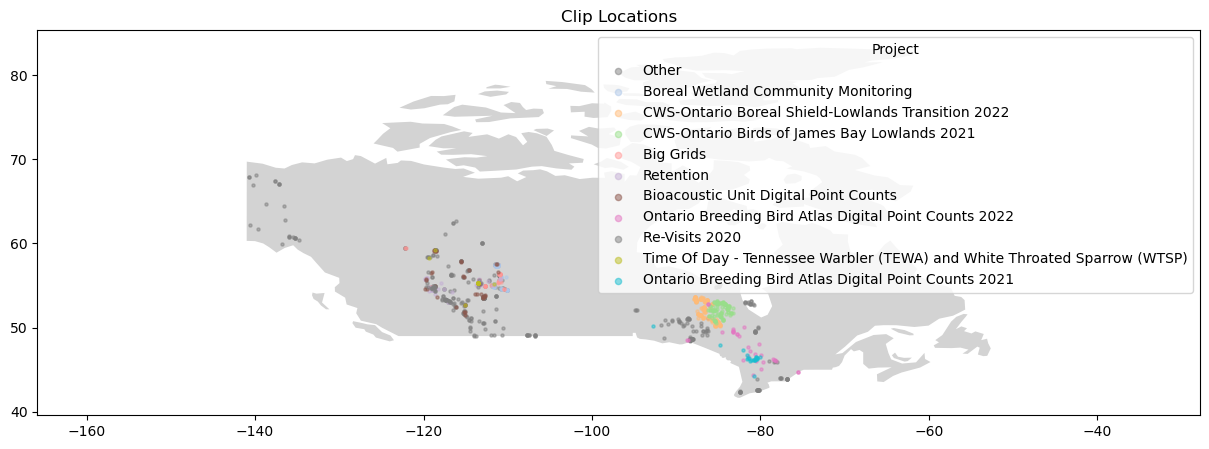

/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/notebooks/exploratory_nbs/../../src/utils.py:50: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  canada = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres")).query(
/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/notebooks/exploratory_nbs/../../src/utils.py:70: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  points.plot(


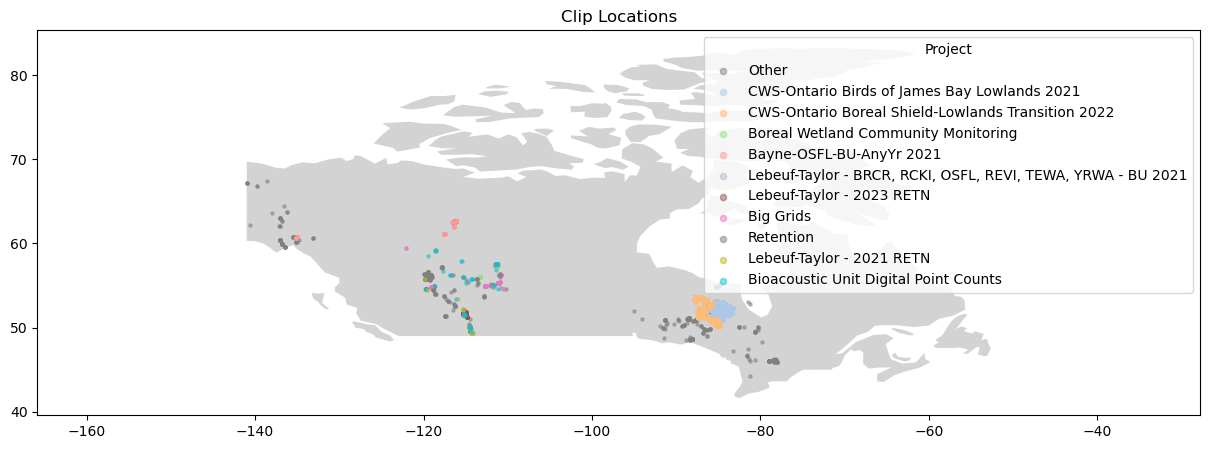

(None, None)

In [49]:
plot_locations(df_lite), plot_locations(osfls)

In [50]:
# reformat the df so that unique recording_urls are shown, and the species_code and recording_date_time are also shown

df.groupby('recording_id').count()


,organization,project,project_id,recording_date_time,species_code,species_common_name,detection_time,task_duration,tag_duration,tag_id,clip_url,recording_url,latitude,longitude,file_type
recording_id,,,,,,,,,,,,,,,
3557,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
3560,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
3562,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
3564,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
3567,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
826381,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
826382,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
826383,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
